## Regression Dive

I'd like to be as thorough in my understanding as possible, so this my be slow but it will be very rigorous.

**Note**: As of September 22, I read an article for some tips and tricks in Jupyter. I've intermixed notes regarding these tips and tricks, so not all cells are exclusively devoted to regression.

In [101]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

np.random.seed(42)

Above we imported seaborn, another plotting and visualization library that sits on top of matplotlib. It will make the visualizations look _slightly_ better.

I was having trouble understanding the notation for linear regression. It turns out I was mixing up the concept of training the model vice using the model equation to make the prediction.

We see a typical linear regression model displayed as follows:

$\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_nx_n$

**This is the formula used to make the prediction. I was confusing the model formula with the training formula, which different.**

Each $x_n$ represents a feature of the data, for example, a feature of the housing data would be median income or bedrooms per household or proximity to water, etc. Each $\theta_n$ represents a weight that was trained using the training data to generate our linear regression model. He covers the normal equation in the next section. Each feature will have its own $\theta$ that was generated for that feature. 

We then put this into a "simpler" form:

$\hat{y} = \theta^{T}\cdot\textbf{x}$

This is a vectorized form of the equation before it. $\hat{y}$ still represents the prediction. $\theta$ is a column vector consisting of each feature's weight. **x** is a column vector of each feature. In order to get the same expression as the function above, we perform a dot product between $\theta$ and **x**. **In order to perform a dot product between these two vectors, we have to transpose one of them; thus, we transpose $\theta$.** (The first vector must have the same number of columns as the second vector's number of rows.)

We would then get the same expression as above. See! Not too hard! (Took me a while to figure that out since I'm still building my familiarity with vector notation.)

Aurelien covers the normal equation that outputs a $\theta$ that reduces the cost function. **I'll take this as a lookup to see how exactly this equation does this.**

$\hat{\theta} = (\textbf{X}^{T}\cdot\textbf{X})^{-1}\cdot\textbf{X}^{T}\cdot\textbf{y}$

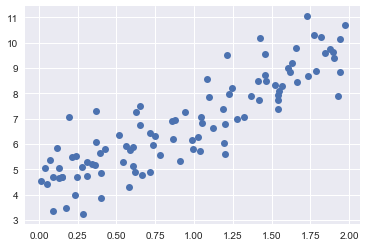

In [102]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'o')

In [103]:
X_b = np.c_[np.ones((100, 1)), X] # add 1 to each instance

In [104]:
print(np.linalg.inv(X_b.T.dot(X_b)))
print(X_b.T.dot(X_b))
print(1/94.03614868)

[[ 0.03523199 -0.02683222]
 [-0.02683222  0.02853394]]
[[ 100.           94.03614868]
 [  94.03614868  123.47395265]]
0.01063420837664191


Taking an inverse of a matrix is a little more complicated than I thought. I originally tried to take the inverse of X_b above, but I got an error. This is because only square matrices can be inversed. 

$A = \begin{bmatrix}
a & b \\
c & d
\end{bmatrix}$

$A^{-1} = \cfrac{1}{ad - bc}\begin{bmatrix}
d & -b \\
-c & a
\end{bmatrix}$

This gets a little more complicated with matrices of dimensions greater than 2 x 2. 

From my understanding through searches on the internet, this column of ones is required in order to deduce the y-intercept or the _bias_ of the data set.

In [105]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best # expect different numbers than the book b

array([[ 4.21509616],
       [ 2.77011339]])

Aurelien mentions $\theta_0 = 3.865$ and $\theta_1 = 3.139$. I don't know what he's referring to here.

In [106]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.21509616],
       [ 9.75532293]])

[0, 2, 0, 15]

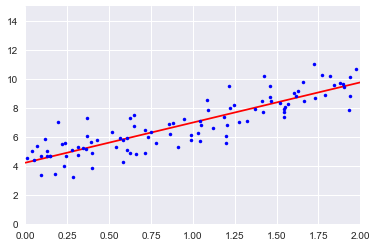

In [107]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])

To clarify what we did here, we simply added two new data points at the extremes of our plot in order to draw the line. The 0 is equal to the y-intercept and 2 is at the far right of our plot. This is just to show the line!

Of course, sklearn provides these calculations in one convenient class.

In [108]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 4.21509616]), array([[ 2.77011339]]))

In [109]:
lin_reg.predict(X_new)

array([[ 4.21509616],
       [ 9.75532293]])

### Really important note

The operation $X^{T}\cdot X$'s computational compexity is about $O^{2.4-3}$ depending on the implementation. If you double the number of features, you multiply the computation by roughly $2^{2.4}$ to $2^{3}$. Expect this computation to get noticeably slower as the number of features grow. **BUT** it's linear when it comes to the number of instances. 

I went back to being confused because I couldn't understand where our prediction values and the theta were coming from. It seemed like you needed one to determine the other value. Sal explains a two dimensional, algebraic example here: https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data/more-on-regression/v/second-regression-example

What to glean from this is that we don't have to have a starting value from the start. We can get both m and b ($\theta_0$, $\theta_1$) from the values themselves. This is what the normal equation does, and, I think, this is a vectorized form of the mean squared error formula. The reason that we use gradient descent in the following secctions is that it is computationally expensive as the number of features and instances grow. Gradient descent helps us reach the value of $\theta$ faster.

## Gradient Descent

In order to find the $\theta$ that reduces the cost function as quickly as possible, we take the partial derivate of the mean squared error function with respect to $\theta$. Gradients point in the direction of steepest ascent, So this will constantly point us in the direction of the min. However, we have to adjust the steps we take as we descend, otherwise, we may skip over the minimum. Gradient descent is a constant battle of balancing # iterations vs the size of the steps. Lastly, we find the gradient descent by subtracting the descent form the last $\theta$.

$\theta^{next step} = \theta - \eta\nabla_{\theta}MSE(\theta)$

In [110]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)
thetas = [] # I added a list of thetas in here because I was curious when the iterations I wasted. 
# Goes to show that maybe 1000 is a little much.

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    thetas.append(theta)

Above, we have an implementation of **batch gradient descent**. It performs the calculations on all the data at each step. This is fine if we require a more precise value for $\theta$ or if our data isn't excessively large. IF we need to reduce the iterations further, we can perform **stochastic gradient descent**. This takes a random sample of data at each step, so the MSE may vary, though it will consistently reduce in aggregate (until it gets close to the min, where it will still settle at random numbers near the min). It will not give an optimal min of $\theta$.

Additionally, the random nature of the SGD helps it break out of local minima, thus enabling it to find the globals.

Since it will never actually settle out at a minimum, we perform _simulated annealing_, by which we reduce the learning rate over time (it's put on a _learning schedule_).

In [111]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [112]:
theta

array([[ 4.18475289],
       [ 2.73036719]])

**Reminder**: I'm projecting x and y onto the 3D model I've commonly seen on the internet. This is confusing me. https://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/ That image's axes are the y-intercept($\theta_0$), the slope($\theta_1$), and the error (MSE in this case). Do not confuse these axes with the data points in the dataset.

I'm almost there, but I still don't know what part the data itself is playing in finding the $\theta_0$ and $\theta_1$. I don't understand how subtracting a gradient from a given theta will allow us to arrive at our answers. 

Below is how to do this using sklearn.

In [113]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) # ravel() flattens out y into a 1D array
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.2287996]), array([ 2.79011436]))

## Polynomial Regression

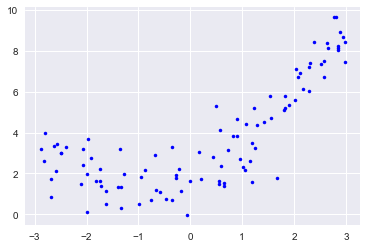

In [114]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.plot(X, y, 'b.')

In [115]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([ 2.94407494])

In [116]:
X_poly[0]

array([ 2.94407494,  8.66757727])

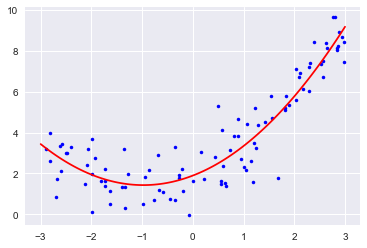

In [117]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_
X_new=np.linspace(-3, 3, 100).reshape(100, 1) # Generates 100 numbers evenly spaced between -3 and 3, inclusive
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-')

I think the lesson to glean from this is that you should look at your data and determine if a polynomial function would better fit than a linear model. sklearn provides the tools to do this.

## Learning Curves

We can see what is happening to our model has we add more data.

In [118]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label="val")
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14) 
    plt.legend()

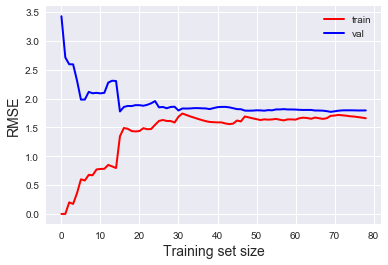

In [119]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

This is normal linear regression line being attached to our quadratic looking data. It is underfitting the data. Additionally, the training data fits perfectly at with 1-2 data points then the RMSE increases to a plateau as more data is added. This is because the line can't possibly fit all the data perfectly without overfitting. For validation line, with so few data points used to train the model, it does not generalize well at the beginning, thus a larger RMSE. This shrinks as more data is added.

**Note**: Models that underfit the data will not benefit from more data. (Any model will benefit from more data up until a point, which you can see here.) A more complex model is required to reduce MSE further.

[0, 80, 0, 3]

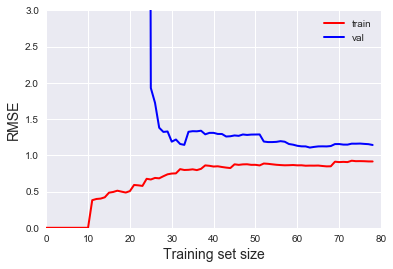

In [120]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("sgd_reg", LinearRegression()),
))

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])  

Overfitting models can be improved by feeding them more data.

### Bias/Variance Tradeoff

_Bias_: Incorrect assumptiosn resulting in underfitting a model, overgeneralizing the data. 

_Variance_: Overfitting a model results in excessive sensitivity to small variations in the data. It varies widely, thus a higher variance.

_Irreducible error_: Noisiness within the data itself. It can be reduced by cleaning up the data as much as possible.

This is a tradeoff since increasing variance will reduce bias and vice versa. Joel Grus makes a good graph of this in _Data Science from Scratch_.

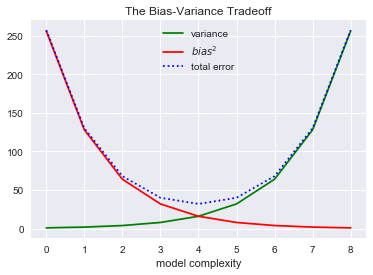

In [121]:
variance = [1, 2, 4, 8, 16, 32, 64, 128, 256]
bias_squared = variance[::-1]
total_error = [x + y for x, y in zip(variance, bias_squared)]
xs = [i for i, _ in enumerate(variance)]

plt.plot(xs, variance, 'g-', label='variance')
plt.plot(xs, bias_squared, 'r-', label='$bias^2$')
plt.plot(xs, total_error, 'b:', label='total error')
plt.legend()
plt.xlabel("model complexity")
plt.title("The Bias-Variance Tradeoff")

## Ridge Regression

A *regularized* version of linear regression. Essentially, we add a regularization term to the cost function that will keep the weights at a minimum, while also fitting the data. This particular type of regression is also called *Tikhonov regularization*, and its regularization term is $\alpha\sum^{n}_{i=1}\theta^{2}_i$. $\alpha$ is the hyperparameter that will be adjusted for fit, and the ridge regression will turn into plain old linear regression if it is equal to 0.

The data needs to be scaled since it is sensitive to input features.

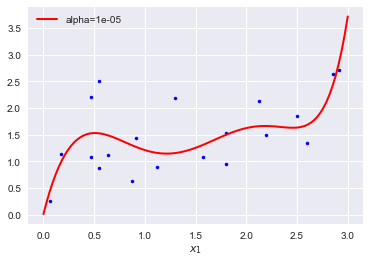

In [122]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

ridge = Ridge(alpha=10**-5, random_state=42)
ridge_pipe = Pipeline([("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                       ("std_scaler", StandardScaler()),
                       ("regul_reg", ridge)])
ridge_pipe.fit(X, y)
y_new = ridge_pipe.predict(X_new)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", lw=2, label="alpha={}".format(10**-5))
plt.xlabel("$x_1$")
plt.legend()

You can look at Aurelien's notebook to see how different values of alpha changes the look of the graph. We're using a polynomial model here, so if alpha was 0, it would vary widely, but if alpha was one, it would be linear. Finding the right alpha can help us find the right balance between variance and bias.

Our ridge regression cost function $J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum^{n}_{i=1}\theta^{2}_i$ turns into a variation of the closed-form Normal Equation:
$$\hat{\theta} = (X^T\cdot X + \alpha A)^{-1}\cdot X^T\cdot y$$

where **A** is the *n X n* identity matrix except with 0 in the first row in the first column to account for the bias term.

In [123]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 1.55071465]])

In [124]:
# stochastic gradient descent

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([ 1.12795912])

The penalty is the regularization term, in this case l2 means to take the half of the square of the l2 norm of the weight vector (Described on the previous page in the book.)

## Lasso Regression

**L**east **a**bsolute **s**hrinkage and **s**election **o**perator regression.

This is very similar to ridge regression, but use the norm of the weight vector $\mathscr{l}_1$ instead of its half and square $\mathscr{l}_2$

$J(\theta) = MSE(\theta) + \alpha\sum^{n}_{i=1}|\theta_i|$

From what I can glean, without squaring and halving the  $\mathscr{l}_2$, we end up dampening high-degree polynomial features so severely that they are either 0 or effectively 0. This in turn ends up with a sparse model. We can use this with gradient descent if we use a subgradient vector.

Aurelien doesn't go into much depth here, so I'll have to do some more learning on my own.

In [125]:
from sklearn.linear_model import Lasso

lass_reg = Lasso(alpha=0.1)
lass_reg.fit(X, y)
lass_reg.predict([[1.5]])

array([ 1.53788174])

## Elastic Net

A literal combination of Lasso and Ridge regression. 

$J(\theta) = MSE(\theta) + r\alpha\sum^{n}_{i=1}\mid\theta_i\mid + \frac{1-r}{2}\alpha\sum^{n}_{i=1}\theta^{2}_i$

Aurelien's tips on choosing which one to use:

- Generally, try to avoid Linear Regression, a little variation generally works better than a straight line.

- Ridge is a good default, but if you suspect some features aren't useful, Lasso could be used to drop those weights to zero.

- Lasso may behave erratically when the number of features is greater than the number of training instances, so Elastic Net is generally preferred over Lasso.

In [126]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([ 1.54333232])

## Early Stopping

After a number of epochs, gradient descent levels out at the minimum value. But if it continues to be trained, it will start to go back up and overfit the training data. Early stopping allows us to stop training as soon as we hit the minimum RMSE. ("beautiful free lunch")

Sometimes it can be difficult to know when we've arrived at the minimum. What we can do is watch the minimum for sometime, ensure that it has stabilized and use this as the minimum. Or we can wait until the minimum starts to go back up and roll back to the parameters where the minimum was.

In [127]:
from sklearn.base import clone

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_ref = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

## Logistic Regression

Regression for binary classification.

Behaves very similarly to linear regression, but outputs a logistic of the result:

$\hat{p}=h_{\theta}(x)=\sigma(\theta^{T}\cdot x)$

where

$\sigma(t) = \frac{1}{1 + e^{-t}}$

This _logit_ is a sigmoid function (S-shaped). It's cost function is a little different:

$J(\theta) = \frac{1}{m}\sum^m_{i=1}[y^{(i)}log(\hat{p^{(i)}}) + (1 - y^{(i)})log(1 - \hat{p^{(i)}})]$



## Decision Boundaries

We'll use the iris dataset and logistic regression to predict flower species in this famous dataset.

In [128]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

## Reminder:

#### Notice the difference between the two 'queries' on this data set. The first returns the third column as a 1D array, whereas the second returns the column as an actual column.

I converted these cells to raw since I didn't need their output.

The iris dataset is imported as a dictionary with the data as a value in the dictionary. I guess we're going to be making our classifications using the petal width. Aurelien doesn't really explain why he jumps immediately to the petal width as the independent variable.

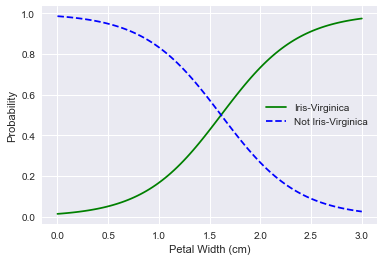

In [129]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

X_new = np.linspace(0, 3, 100).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")
plt.plot()
plt.xlabel("Petal Width (cm)")
plt.ylabel("Probability")
plt.legend()

Where the lines cross is the decision boundary.

In [130]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Logistic Regression models can be regularized, but it uses *C*, which is its inverse. The higher the value of C, the less the model is regularized.